In [26]:
from typing import Tuple, List
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

Data

In [27]:
hum = pd.read_csv('nuclear-waste/Training_data_humidity.csv')
pre = pd.read_csv('nuclear-waste/Training_data_pressure.csv')

df_tem = pd.read_csv('nuclear-waste/Training_data_temperature.csv')                   
df_sensors = pd.read_csv('nuclear-waste/Coordinates_Training.csv')


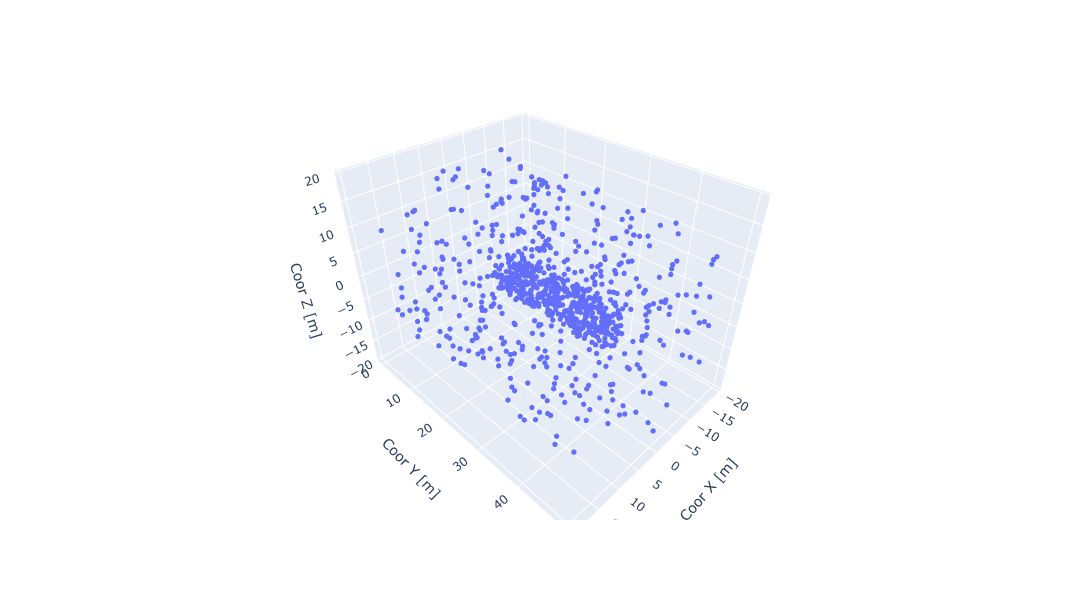

In [28]:
# With the scatter_3d function from plotly, we will visualize the sensors, 

fig = px.scatter_3d(
    df_sensors,
    x='Coor X [m]',
    y='Coor Y [m]',
    z='Coor Z [m]',
    width = 800,
    height = 600,
    hover_name='Sensor ID'  # Facultatif : info au survol
)

fig.update_traces(marker=dict(size=3))

fig.show()


Cylinder shape, disc on XZ plane

In [29]:
# Combining the data on one data frame will facilitate the access to them

df_long = df_tem.melt(id_vars='M.Time[d]', var_name='Sensor ID', value_name='Temperature')

df_merged = df_long.merge(df_sensors[['Sensor ID', 'Index', 'Material','Coor X [m]','Coor Y [m]','Coor Z [m]', 'R [m]']], on='Sensor ID', how='left')

le = LabelEncoder()
df_merged['Material_encoded'] = le.fit_transform(df_merged['Material'])


In [45]:

def replacewithnan(
    df : pd.DataFrame,
    header : str,
    min_val = -float('inf') ,
    max_val = float('inf') ,
) -> int:
    """
    Replace values between a certain interval with NaN

    df : DataFrame
    header : Header of column
    min_val : minimal value of the interval
    max_val : maximal value of the interval
    """
    for i in df[header]:
        if min_val < i < max_val and (type(i) == float or type(i) == str) :
            df.replace(to_replace = i, value = np.NaN, inplace= True)
    return df

replacewithnan(df_merged,'Temperature', 1000.0)

,M.Time[d],Sensor ID,Temperature,Index,Material,Coor X [m],Coor Y [m],Coor Z [m],R [m],Material_encoded
0,1554,N_1,17.623059,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
1,1556,N_1,17.620860,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
2,1558,N_1,17.618608,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
3,1560,N_1,17.616334,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
4,1563,N_1,17.612991,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
...,...,...,...,...,...,...,...,...,...,...
28795,4133,N_900,33.818793,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28796,4779,N_900,34.584776,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28797,5587,N_900,35.289734,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28798,6597,N_900,35.932025,900,OPA,1.950772,36.121381,-3.239393,3.781426,4


In [46]:
# Here we will replace NaNs with another value. As a baseline, NaNs will be 0 for the sake of simplicity (will change it)

def avgcolumn(
    df : pd.DataFrame,
    header : str,
    min_val = -float('inf') ,
    max_val = float('inf') ,
) -> int:
    """
    Returns average of a DateFrame column

    df : DataFrame
    header : Header of column
    min_val : minimal value of the interval
    max_val : maximal value of the interval
    """
    liste = []
    for i in df[header]:
        if min_val < i < max_val and (type(i) == float or type(i) == str)  :
            liste.append(i)
    if len(liste) <=0 :
        return 0
    else :
        return sum(liste)/len(liste)
        
average = avgcolumn(df_merged,'Temperature', 0.0, 1000.0)

df_merged = df_merged.fillna(average)
df_merged

,M.Time[d],Sensor ID,Temperature,Index,Material,Coor X [m],Coor Y [m],Coor Z [m],R [m],Material_encoded
0,1554,N_1,17.623059,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
1,1556,N_1,17.620860,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
2,1558,N_1,17.618608,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
3,1560,N_1,17.616334,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
4,1563,N_1,17.612991,1,OPA,0.208042,14.436936,-2.875503,2.883019,4
...,...,...,...,...,...,...,...,...,...,...
28795,4133,N_900,33.818793,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28796,4779,N_900,34.584776,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28797,5587,N_900,35.289734,900,OPA,1.950772,36.121381,-3.239393,3.781426,4
28798,6597,N_900,35.932025,900,OPA,1.950772,36.121381,-3.239393,3.781426,4


In [47]:
# Now we combine the sets and split them into subsets 

X = df_merged[['M.Time[d]','Coor X [m]','Coor Y [m]','Coor Z [m]','R [m]','Material_encoded']]
X = X.rename(columns={
    'M.Time[d]': 'Time',
    'Coor X [m]': 'X',
    'Coor Y [m]': 'Y',
    'Coor Z [m]': 'Z',
    'R [m]': 'R',
    'Material_encoded': 'Material'
})
y = df_merged[['Temperature']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

X_train

,Time,X,Y,Z,R,Material
10044,4779,14.898321,29.355198,-3.852742,15.388424,4
11730,1895,-16.144280,18.647610,-10.869867,19.462573,4
1080,2871,7.011154,40.076919,12.700717,14.507394,4
28308,2090,2.042172,21.169177,-2.819816,3.481642,4
27409,1826,-1.306057,21.854072,3.003130,3.274840,4
...,...,...,...,...,...,...
10955,1621,1.269512,41.213464,13.086030,13.147466,4
17289,1595,0.414754,30.743811,1.754827,1.803174,4
5192,1585,-6.966126,9.722279,-13.286847,15.002240,4
12172,1639,3.269436,11.070933,9.216185,9.778920,4


In [48]:
# Linear regression, undoubtedly a bad algorithm for this problem, but will serve as a baseline
# L2 Linear Regression Conclusion
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


In [49]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.4f}")
print(f"R² : {r2:.4f}")

MSE : 125.5139
R² : 0.4602


In [50]:
# L2 Linear Regression Conclusion

In [51]:
# L1 Linear Regression

model2 = Lasso(alpha=0.2)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_val)

In [52]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.4f}")
print(f"R² : {r2:.4f}")

MSE : 125.7355
R² : 0.4592


In [53]:
# L1 Linear Regression Conclusion

In [54]:
# Random Forest Regressor 

rf = RandomForestRegressor(n_estimators=50, max_depth = 20, random_state=5)
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_val)


In [55]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.4f}")
print(f"R² : {r2:.4f}")

MSE : 7.6233
R² : 0.9672


In [56]:
# Random Forest Regressor Conclusion

In [57]:
#XGBoost

xgbm = XGBRegressor(n_estimators=50, max_depth=20, learning_rate=0.1, random_state=5)
xgbm.fit(X_train, y_train)
y_pred = xgbm.predict(X_val)




In [58]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.4f}")
print(f"R² : {r2:.4f}")

MSE : 8.6206
R² : 0.9629


In [ ]:
#XGBoost Conclusion

In [68]:
#cv_scores = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')
#print("MSE in cross_val :", -cv_scores.mean())

In [69]:
# KNN Regressor

knn = KNeighborsRegressor(n_neighbors=100) 
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_val)

In [70]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.2f}")
print(f"R² : {r2:.4f}")

MSE : 128.87
R² : 0.4385


In [ ]:
# KNN Regressor Conclusion

In [71]:
# Gradient Boosting Regression

gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)

In [72]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE : {mse:.2f}")
print(f"R² : {r2:.4f}")

MSE : 9.89
R² : 0.9569


In [ ]:
# Gradient Boosting Regression Conclusion

In [ ]:
# Final Test 

In [ ]:
df_tem['M.Time[d]']

In [ ]:
df_test = pd.read_csv('nuclear-waste/Coordinates_Test.csv')


In [ ]:
le2 = LabelEncoder()
df_test['Material_encoded'] = le2.fit_transform(df_test['Material'])
df_test["key"] = 1
df_times = pd.DataFrame({"M.Time[d]": df_tem['M.Time[d]']})
df_times["key"] = 1
df_test_prepared = pd.merge(df_test, df_times, on="key").drop("key", axis=1)

In [ ]:
df_test_prepared = df_test_prepared[['M.Time[d]','Coor X [m]', 'Coor Y [m]', 'Coor Z [m]', 'R [m]', 'Material_encoded']]

df_test_prepared = df_test_prepared.rename(columns={
    'M.Time[d]': 'Time',  
    'Coor X [m]': 'X',
    'Coor Y [m]': 'Y',
    'Coor Z [m]': 'Z',
    'R [m]': 'R',
    'Material_encoded': 'Material'
})

X_test = df_test_prepared[['Time','X', 'Y', 'Z', 'R', 'Material']]

X_test

In [ ]:
y_pred_t = xgbm.predict(X_test)